## ECE 498 DS - Mini-Project 2:  MiMoSA 
##### MiMoSA (Mixture Model-based Single-cell Analysis) is a workflow to cluster single-cells using RPKM measure output by the MapRSeq pipeline developed at Mayo Clinic.

### Originally developed by Arjun Athreya (athreya2@illinois.edu) in R 
### Research Paper available at http://ieeexplore.ieee.org/abstract/document/7822581/

#### ECE 498 DS Staff (Saurabh Jha and Lavin Devnani adapted the code for Python and Jupyter Notebook)


# Import Packages for Working With the Datasets
* pandas - to load datasets
* numpy - vector manipulation
* matplotlib - plotting/visualization
* sklean - scikit learning package containg ML algorithm implementations
* seaborn - plotthing/visualization

In [4]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from scipy import stats

import seaborn as sns
# %matplotlib notebook
sns.set_style('whitegrid')

# Biology Primer

## What is a gene?
A gene is a sequence of DNA or RNA which codes for a molecule that has a function.

https://en.wikipedia.org/wiki/Gene

https://www.youtube.com/watch?v=ONGdehkB8jU

## What is a cell?
The cell  is the basic structural, functional, and biological unit of all known living organisms. A cell is the smallest unit of life that can replicate independently, and cells are often called the "building blocks of life". 

https://en.wikipedia.org/wiki/Cell_(biology)

## What is a gene expression?
Gene expression is the activity level of a gene.

https://en.wikipedia.org/wiki/Gene_expression

## What is RPKM?
**RPKM** is reads per kilobase per million mapped reads, which is how many reads (short sequences from a sequencing machine) map to a region of a gene. So at large without loosing generality, better the RPKM better the quality of the gene expression data. 

### You may skip the details about RPKM below
The expression value for each gene was normalized by accounting for the sequencing depth (number of short DNA sequence strings from the sequencing platform aligned to a gene) and length of the gene. The measure of gene expression is Reads Per Kilo Million (RPKM). The range of the RPKM is between 0 and 2, 000.

**Formula**

RPKM =   numReads / ( geneLength/1000 * totalNumReads/1,000,000 )

numReads - number of reads mapped to a gene sequence

geneLength - length of the gene sequence

totalNumReads - total number of mapped reads of a sample


# Import your dataset into the pandas dataframe
### Recall that our experiment consists of two different datasets
   1. Baseline: Cells are not treated with metformin
   2. Metformin: Cells are treated with metformin
   

In [5]:
baseline_csv = pd.read_csv("498DS_BaselineData.csv")
metformin_csv = pd.read_csv("498DS_MetforminData.csv")

# Exploring Pandas Dataframe
## You would want to run the following commands associated with pandas to explore the pandas dataframes
 1. head - helps to visualize first few rows and first few columns, e.g. usage 
   ```python 
   baseline_csv.head()
   ```
 2. len - returns number of rows or columns in the dataset based on the usage, e.g. usage
   ```python
   # return number of rows
   len(baseline_csv)
   # returns number of columns
   len(baseline_csv.columns)
   ```
 3. list - returns list of all columns, e.g. usage
    ```python 
    list(baselines_csv)
    ```
 4. columns - returns columns of the dataframe. This command does not print all columns depending on notebook settings., e.g. usage
    ```python
    baseline_csv.columns
    ```

In [6]:
baseline_csv.head()

,Chr,GeneID,StartCoding,Stop,CodingLength,s_62_M2_N701_S502_RPKM,s_62_M2_N701_S503_RPKM,s_62_M2_N701_S504_RPKM,s_62_M2_N701_S505_RPKM,s_62_M2_N701_S506_RPKM,...,s_85_M2_N711_S501_RPKM,s_85_M2_N711_S502_RPKM,s_85_M2_N711_S503_RPKM,s_85_M2_N711_S504_RPKM,s_85_M2_N711_S506_RPKM,s_85_M2_N711_S507_RPKM,s_85_M2_N711_S508_RPKM,s_85_M2_N712_S503_RPKM,s_85_M2_N712_S504_RPKM,s_85_M2_N712_S505_RPKM
0,chr1,AKR1A1,46016455,46035723,1580,0.000000,0.000000,14.531662,14.268424,26.459120,...,0.000000,0.0,1.037722,24.391142,17.188837,0.000000,2.173159,48.894683,9.213393,0.000000
1,chr1,ANP32E,150190717,150208504,3553,263.583489,0.000000,871.851991,439.864123,575.552858,...,526.275026,0.0,454.455263,587.120601,469.683190,565.316349,343.552412,236.214451,838.993154,141.792692
2,chr1,ARF1,228270361,228286913,2198,41.926167,486.847569,110.116896,156.263029,51.559562,...,148.414035,0.0,36.850006,106.643195,78.107210,40.569316,104.663612,92.728846,80.468384,32.867866
3,chr1,ARPC5,183595332,183604985,1982,63.349868,0.000000,139.493933,170.281826,184.750299,...,30.830665,0.0,184.144951,65.880840,60.437829,70.357630,150.501134,94.707269,144.506633,58.816776
4,chr1,ATP5F1,111991743,112004525,2101,327.593082,0.000000,221.522538,311.490830,207.609025,...,221.936539,0.0,175.275819,141.346657,177.968802,189.485482,113.785720,198.088156,76.215503,37.511264


In [7]:
metformin_csv.head()

,Chr,GeneID,Start,Stop,CodingLength,s_63_M2_N701_S501_RPKM,s_63_M2_N701_S502_RPKM,s_63_M2_N701_S503_RPKM,s_63_M2_N701_S504_RPKM,s_63_M2_N701_S505_RPKM,...,s_204_M2_N712_S501_RPKM,s_204_M2_N712_S502_RPKM,s_204_M2_N712_S503_RPKM,s_204_M2_N712_S504_RPKM,s_204_M2_N712_S505_RPKM,s_204_M2_N712_S506_RPKM,s_204_M2_N712_S507_RPKM,s_204_M2_N712_S508_RPKM,s_lane1_Undetermined_RPKM.1,s_lane2_Undetermined_RPKM.1
0,chr1,ANKRD36BP1,168214819,168216668,1850,0.440043,0.000000,12.693285,27.412660,7.378925,...,0.141431,4.867474,0.000000,2.293990,0.000000,2.508867,1.699676,10.164217,6.560453,4.703404
1,chr1,ANP32E,150190717,150208504,3553,517.592029,10.749289,754.147392,534.208422,356.355539,...,1533.653888,586.403579,571.360726,1441.236773,793.018158,439.711955,504.272351,634.004705,622.270556,633.534112
2,chr1,APOA1BP,156561558,156564091,1121,79.882864,0.608389,1.102520,5.517006,6.088765,...,44.580451,65.266924,0.000000,9.043854,13.633060,0.414041,38.147951,96.536841,47.216858,48.830575
3,chr1,ARF1,228270361,228286913,2198,231.482884,70.434447,73.379540,139.279295,166.755975,...,319.976644,99.860175,0.000000,86.242051,50.008005,134.934356,19.741917,156.957326,148.013958,152.447260
4,chr1,ARPC5,183595332,183604985,1982,162.240771,59.185012,164.311943,123.878491,244.505991,...,205.146479,135.163275,0.000000,135.491107,155.697364,77.512851,121.841571,151.602966,132.166204,136.973007


In [8]:
print("Number of rows %d" % len(baseline_csv))
print("Number of columns %d" % len(baseline_csv.columns))

Number of rows 1170
Number of columns 174


In [9]:
list(baseline_csv)

['Chr',
 'GeneID',
 'StartCoding',
 'Stop',
 'CodingLength',
 's_62_M2_N701_S502_RPKM',
 's_62_M2_N701_S503_RPKM',
 's_62_M2_N701_S504_RPKM',
 's_62_M2_N701_S505_RPKM',
 's_62_M2_N701_S506_RPKM',
 's_62_M2_N701_S507_RPKM',
 's_62_M2_N701_S508_RPKM',
 's_62_M2_N702_S501_RPKM',
 's_62_M2_N702_S502_RPKM',
 's_62_M2_N702_S503_RPKM',
 's_62_M2_N702_S504_RPKM',
 's_62_M2_N702_S505_RPKM',
 's_62_M2_N702_S506_RPKM',
 's_62_M2_N702_S507_RPKM',
 's_62_M2_N702_S508_RPKM',
 's_62_M2_N703_S501_RPKM',
 's_62_M2_N703_S502_RPKM',
 's_62_M2_N703_S504_RPKM',
 's_62_M2_N703_S505_RPKM',
 's_62_M2_N703_S506_RPKM',
 's_62_M2_N703_S507_RPKM',
 's_62_M2_N703_S508_RPKM',
 's_62_M2_N704_S501_RPKM',
 's_62_M2_N704_S502_RPKM',
 's_62_M2_N704_S503_RPKM',
 's_62_M2_N704_S504_RPKM',
 's_62_M2_N704_S505_RPKM',
 's_62_M2_N704_S506_RPKM',
 's_62_M2_N704_S507_RPKM',
 's_62_M2_N704_S508_RPKM',
 's_62_M2_N705_S501_RPKM',
 's_62_M2_N705_S502_RPKM',
 's_62_M2_N705_S504_RPKM',
 's_62_M2_N705_S505_RPKM',
 's_62_M2_N705_S506_R

In [10]:
list(metformin_csv)

['Chr',
 'GeneID',
 'Start',
 'Stop',
 'CodingLength',
 's_63_M2_N701_S501_RPKM',
 's_63_M2_N701_S502_RPKM',
 's_63_M2_N701_S503_RPKM',
 's_63_M2_N701_S504_RPKM',
 's_63_M2_N701_S505_RPKM',
 's_63_M2_N701_S507_RPKM',
 's_63_M2_N701_S508_RPKM',
 's_63_M2_N702_S501_RPKM',
 's_63_M2_N702_S502_RPKM',
 's_63_M2_N702_S504_RPKM',
 's_63_M2_N702_S505_RPKM',
 's_63_M2_N702_S506_RPKM',
 's_63_M2_N702_S507_RPKM',
 's_63_M2_N702_S508_RPKM',
 's_63_M2_N703_S502_RPKM',
 's_63_M2_N703_S504_RPKM',
 's_63_M2_N703_S505_RPKM',
 's_63_M2_N703_S506_RPKM',
 's_63_M2_N703_S507_RPKM',
 's_63_M2_N703_S508_RPKM',
 's_63_M2_N704_S501_RPKM',
 's_63_M2_N704_S502_RPKM',
 's_63_M2_N704_S504_RPKM',
 's_63_M2_N704_S505_RPKM',
 's_63_M2_N704_S506_RPKM',
 's_63_M2_N704_S507_RPKM',
 's_63_M2_N704_S508_RPKM',
 's_63_M2_N705_S502_RPKM',
 's_63_M2_N705_S504_RPKM',
 's_63_M2_N705_S505_RPKM',
 's_63_M2_N705_S506_RPKM',
 's_63_M2_N705_S507_RPKM',
 's_63_M2_N705_S508_RPKM',
 's_63_M2_N706_S501_RPKM',
 's_63_M2_N706_S502_RPKM',


In [11]:
baseline_csv.columns

Index(['Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength',
       's_62_M2_N701_S502_RPKM', 's_62_M2_N701_S503_RPKM',
       's_62_M2_N701_S504_RPKM', 's_62_M2_N701_S505_RPKM',
       's_62_M2_N701_S506_RPKM',
       ...
       's_85_M2_N711_S501_RPKM', 's_85_M2_N711_S502_RPKM',
       's_85_M2_N711_S503_RPKM', 's_85_M2_N711_S504_RPKM',
       's_85_M2_N711_S506_RPKM', 's_85_M2_N711_S507_RPKM',
       's_85_M2_N711_S508_RPKM', 's_85_M2_N712_S503_RPKM',
       's_85_M2_N712_S504_RPKM', 's_85_M2_N712_S505_RPKM'],
      dtype='object', length=174)

In [12]:
baseline_csv['GeneID'].tolist()

['AKR1A1',
 'ANP32E',
 'ARF1',
 'ARPC5',
 'ATP5F1',
 'ATP6V0B',
 'ATPIF1',
 'C1orf122',
 'C1orf123',
 'C1orf133',
 'C1orf159',
 'C1orf31',
 'C1orf35',
 'C4BPB',
 'CACYBP',
 'CAPZA1',
 'CCT3',
 'CDC20',
 'CDC42',
 'CDCA8',
 'CKS1B',
 'CNIH4',
 'CNN3',
 'CTPS',
 'CYR61',
 'DDAH1',
 'DDOST',
 'DNAJC8',
 'DNTTIP2',
 'EFHD2',
 'EIF3I',
 'ENO1',
 'F3',
 'FBXO6',
 'G0S2',
 'GAS5',
 'GNG5',
 'GNPAT',
 'HBXIP',
 'HMGN2',
 'HNRNPR',
 'HSPB11',
 'ILF2',
 'ISG15',
 'JTB',
 'KDM1A',
 'KIF2C',
 'KRTCAP2',
 'LSM10',
 'MFSD2A',
 'MGST3',
 'MINOS1',
 'MRPL37',
 'MRPL55',
 'MRPS15',
 'MRPS21',
 'NDUFS5',
 'NME7',
 'NOC2L',
 'PARK7',
 'PFDN2',
 'PPOX',
 'PRDX1',
 'PRDX6',
 'PSMB4',
 'PSMD4',
 'RASAL2',
 'RHOC',
 'RPA2',
 'RPF1',
 'RPL11',
 'RPL5',
 'RPS27',
 'RPS8',
 'S100A10',
 'S100A11',
 'S100A16',
 'S100A4',
 'S100A6',
 'SCAMP3',
 'SDHB',
 'SEC22B',
 'SEP15',
 'SF3A3',
 'SH3BGRL3',
 'SLC39A1',
 'SLC50A1',
 'SNHG3',
 'SNORA61',
 'SNORD47',
 'SNORD80',
 'SNORD99',
 'SNRPE',
 'SRP9',
 'SSR2',
 'STMN1',


In [13]:
metformin_csv['GeneID'].tolist()

['ANKRD36BP1',
 'ANP32E',
 'APOA1BP',
 'ARF1',
 'ARPC5',
 'ATP5F1',
 'ATP6V0B',
 'BCAS2',
 'C1orf123',
 'C1orf31',
 'C1orf54',
 'CACYBP',
 'CAP1',
 'CAPZA1',
 'CCT3',
 'CDA',
 'CDC20',
 'CDC42',
 'CDCA8',
 'CENPF',
 'CKS1B',
 'CNIH4',
 'CNN3',
 'COL8A2',
 'CTPS',
 'CYR61',
 'DAP3',
 'DDAH1',
 'DDOST',
 'DNAJC8',
 'DNTTIP2',
 'DPM3',
 'EBNA1BP2',
 'EFHD2',
 'EIF2D',
 'EIF3I',
 'ENO1',
 'F3',
 'FDPS',
 'G0S2',
 'GAS5',
 'GGPS1',
 'GNG5',
 'GSTM3',
 'GTF2B',
 'HBXIP',
 'HMGN2',
 'HSPB11',
 'ILF2',
 'KDM1A',
 'KRTCAP2',
 'LAMTOR2',
 'LZIC',
 'MED18',
 'METTL18',
 'MFSD2A',
 'MGST3',
 'MINOS1',
 'MRPL55',
 'MRPS14',
 'NDUFS2',
 'NDUFS5',
 'NME7',
 'NOC2L',
 'NUF2',
 'PARK7',
 'PFDN2',
 'PINK1',
 'PPT1',
 'PRDX1',
 'PRDX6',
 'PRPF38A',
 'PSMB4',
 'PSMD4',
 'RABGGTB',
 'RHOC',
 'RPA2',
 'RPL11',
 'RPL5',
 'RPS27',
 'RPS8',
 'S100A10',
 'S100A11',
 'S100A16',
 'S100A4',
 'S100A6',
 'SCAMP3',
 'SDHB',
 'SEC22B',
 'SEP15',
 'SF3A3',
 'SH3BGRL3',
 'SMYD3',
 'SNHG12',
 'SNHG3',
 'SNORA61',
 'SNORA

# Notes
1. There are only 1170 rows and 174 columns
2. Not all columns are important for data analysis/clustering. E.g., Chr, GeneID, StartCoding, Stop, CodingLength are description about the feature and has relevance to biology
3. These datasets are already downsized from 23,398 genes to 1170 genes and 192 cells to 169 cells. Only 20% of the 23, 398 genes show expression levels greater than 32 on the RPKM scale, which is a heuristic that can be used to decide whether a gene is expressed or not as recommended by MAP-Rseq[1]. Roughly 10% of the baseline and metformin-treated cells had low sequencing coverage (< 1M reads per cell), so we excluded those cells from our analysis.

#### References
1. K. R. Kalari, A. A. Nair, J. D. Bhavsar, D. R. OBrien, J. I. Davila, M. A. Bockol, J. Nie, X. Tang, S. Baheti, J. B. Doughty et al., “Map- rseq: mayo analysis pipeline for rna sequencing,” BMC bioinformat- ics, vol. 15, no. 1, p. 1, 2014

# Visualizing datasets
## Plot 1 - Variation of gene expression across different genes for selected cells

## Plot 2 - Variation of gene expression across the cells for a given gene **ARPC5** or **CDC42**

baseline Index:1006, Metformin Index:1016


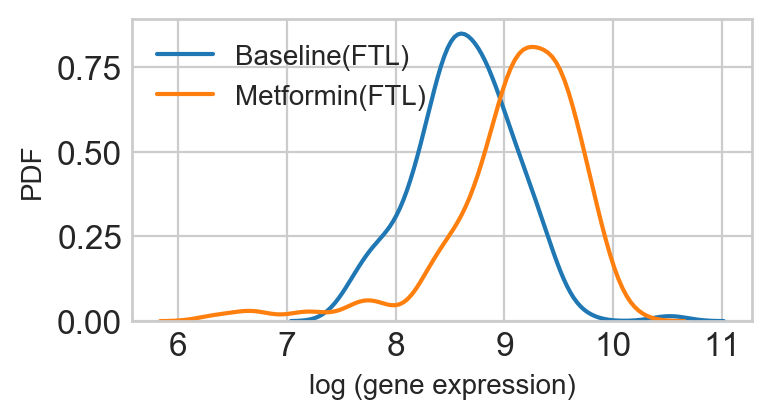

# Comparing the distributions

In [14]:
baselineT = baseline_csv.transpose()
metforminT = metformin_csv.transpose()
geneNames = set(baseline_csv['GeneID'].tolist()).intersection(set(metformin_csv['GeneID'].tolist()))
print("%d genes common in both dataset" % len(geneNames))
numDifferentlyExpressedGene = 0
candidateGenes = set()
for selectGene in geneNames:
    bIndx = baselineT[1:2:].transpose()['GeneID'].tolist().index(selectGene)
    mIndx = metforminT[1:2:].transpose()['GeneID'].tolist().index(selectGene)
    b = np.log(baselineT[bIndx].iloc[6:169].astype(float))
    m = np.log(metforminT[mIndx].iloc[6:169].astype(float))
    Vars = {
        "Baseline": b,
        "Metformin": m
    }
    testResult = stats.ks_2samp(Vars['Baseline'], Vars["Metformin"])
    if testResult[1] < 1e-1:
        candidateGenes.add(selectGene)
        numDifferentlyExpressedGene += 1
        print("%d: %s gene is differently expressed in baseline and metformin treated cells" % (numDifferentlyExpressedGene, selectGene))
        print("Test Statistics %f, %g" % (testResult[0], testResult[1]))
        print("With alpha =", i,"there are", numDifferentlyExpressedGene, "differently expressed in baseline and metfromin treated cells")

833 genes common in both dataset
1: MRPS17 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.196319, 0.00310613
2: TMEM116 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.153374, 0.0386069
3: RPL37A gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.251534, 4.89872e-05
4: SCG5 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.312883, 1.46738e-07
5: LINC00152 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.190184, 0.0046241
6: TCP1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
7: SGTA gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.159509, 0.0279753
8: METTL5 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
9: PPP1CB gene is differently express

C:\Users\Yaxin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Yaxin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()



20: PSMD2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
21: SLC35F2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
22: TXNRD1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.220859, 0.000557352
23: NPC2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.208589, 0.00134942
24: ATOX1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.208589, 0.00134942
25: SAP18 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.171779, 0.0141428
26: ADA gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.349693, 2.44958e-09
27: RPL37 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.233129, 0.000218861
28: FTL gene is differently expressed in baseline and metformin 

Test Statistics 0.171779, 0.0141428
92: CSTB gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.147239, 0.0526098
93: CDC20 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.159509, 0.0279753
94: ATP5C1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
95: RPS24 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.184049, 0.0067975
96: ALG8 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.153374, 0.0386069
97: MGST3 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.184049, 0.0067975
98: SUMO1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
99: STMN1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.147239, 0.0526098
100: UBB gene is differently expressed

Test Statistics 0.134969, 0.0940553
172: B2M gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.331288, 2.0068e-08
173: SERF2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.147239, 0.0526098
174: COX6B1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.147239, 0.0526098
175: COX6A1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.171779, 0.0141428
176: ADRM1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.190184, 0.0046241
177: COX4I1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
178: FAM216A gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.159509, 0.0279753
179: RPL12 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.202454, 0.00206028
180: CHCHD2 gene is dif

249: ANXA1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.177914, 0.00986699
250: RPL36 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.263804, 1.69536e-05
251: RPL35A gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.190184, 0.0046241
252: APEX1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
253: CNP gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.153374, 0.0386069
254: AP1S2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
255: MARCKS gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.159509, 0.0279753
256: SET gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
257: PGK1 gene is differently expressed in baseline and metformi